In [1]:
# Manipulação dos dados

import pandas as pd 
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np


# Visualização
import matplotlib.pyplot as plt


# Bibliotecas para o Pipeline e GridSearch
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from category_encoders import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# Modelo a ser usado
from catboost import CatBoostClassifier


# Métricas
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

# Salvar pkl
import joblib
import pickle


### Metadados

In [2]:
# Importando Metadados

metadados = pd.read_csv("outputs/metadados.csv")
metadados.drop('Unnamed: 0', axis=1, inplace=True)
metadados.shape

(122, 6)

In [3]:
metadados.head()

,Features,Role,Level,Keep,Tipo,Cardinality
0,SK_ID_CURR,id,nominal,False,int64,307511
1,TARGET,target,binary,True,int64,2
2,NAME_CONTRACT_TYPE,input,nominal,True,object,2
3,CODE_GENDER,input,nominal,True,object,3
4,FLAG_OWN_CAR,input,nominal,True,object,2


### Tabela de Modelagem

In [4]:
# Carregando Abt
#abt = pd.read_parquet('VARS_M-2_train')
abt = pd.read_csv("abt/application_train.csv")
abt.shape

(307511, 122)

In [5]:
abt.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


### Separar base pra teste (20%)

In [6]:
split = StratifiedShuffleSplit(test_size=0.2)
for x, y in split.split(abt, abt['TARGET']):
    df00 = abt.iloc[x]
    df00_unseen = abt.iloc[y]
    
print('Dados pra treinamento:' + str(df00.shape))
print('Dados pra teste:' + str(df00_unseen.shape))

Dados pra treinamento:(246008, 122)
Dados pra teste:(61503, 122)


# Preparando os dados

### Separando Variáveis explicativas e Alvo

In [7]:
X = df00.drop(['TARGET'], axis=1) # Variáveis Explicativas
y = df00["TARGET"] # Variável Dependente

### Variáveis numéricas

In [8]:
# Filtrando Data Frame 
vars_numericas_df = metadados[((metadados.Level  == 'ordinal')|(metadados.Level == 'interval')) & (metadados.Role == 'input')]
# Selecionando nomes das variáveis a partir do data frame filtrado
vars_numericas_df.head()

,Features,Role,Level,Keep,Tipo,Cardinality
6,CNT_CHILDREN,input,ordinal,True,int64,15
7,AMT_INCOME_TOTAL,input,interval,True,float64,2548
8,AMT_CREDIT,input,interval,True,float64,5603
9,AMT_ANNUITY,input,interval,True,float64,13672
10,AMT_GOODS_PRICE,input,interval,True,float64,1002


In [9]:
# Selecionando nomes das variáveis a partir do data frame filtrado
lista_vars_numericas = list(vars_numericas_df['Features'])
lista_vars_numericas

['CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BEGINEXP

In [10]:
# Salvar a lista em um arquivo
with open('outputs/lista_vars_numericas.pkl', 'wb') as arquivo:
    pickle.dump(lista_vars_numericas, arquivo)



### Variáveis Categóricas

### Variáveis para dummy

In [11]:
# Filtrando Data Frame 
vars_to_dummif_df = metadados[(metadados.Level  == 'nominal') & (metadados.Role == 'input')& (metadados.Cardinality <= 10)]
# Selecionando nomes das variáveis a partir do data frame filtrado
vars_to_dummif_df

,Features,Role,Level,Keep,Tipo,Cardinality
2,NAME_CONTRACT_TYPE,input,nominal,True,object,2
3,CODE_GENDER,input,nominal,True,object,3
4,FLAG_OWN_CAR,input,nominal,True,object,2
5,FLAG_OWN_REALTY,input,nominal,True,object,2
11,NAME_TYPE_SUITE,input,nominal,True,object,7
12,NAME_INCOME_TYPE,input,nominal,True,object,8
13,NAME_EDUCATION_TYPE,input,nominal,True,object,5
14,NAME_FAMILY_STATUS,input,nominal,True,object,6
15,NAME_HOUSING_TYPE,input,nominal,True,object,6
32,WEEKDAY_APPR_PROCESS_START,input,nominal,True,object,7


In [12]:
# Selecionando nomes das variáveis a partir do data frame filtrado
lista_vars_dummif = list(vars_to_dummif_df['Features'])
lista_vars_dummif

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE']

In [13]:
# Salvar a lista em um arquivo
with open('outputs/lista_vars_dummif.pkl', 'wb') as arquivo:
    pickle.dump(lista_vars_dummif, arquivo)



### Variáveis para label encoder

In [14]:
# Filtrando Data Frame 
vars_to_le_df = metadados[(metadados.Level  == 'nominal') & 
                          (metadados.Role == 'input') & 
                          (metadados.Cardinality > 10)]

# Selecionando nomes das variáveis a partir do data frame filtrado
vars_to_le_df

,Features,Role,Level,Keep,Tipo,Cardinality
28,OCCUPATION_TYPE,input,nominal,True,object,18
40,ORGANIZATION_TYPE,input,nominal,True,object,58


In [15]:
# Selecionando nomes das variáveis a partir do data frame filtrado
lista_vars_le = list(vars_to_le_df['Features'])
lista_vars_le

['OCCUPATION_TYPE', 'ORGANIZATION_TYPE']

In [16]:
# Salvar a lista em um arquivo
with open('outputs/lista_vars_le.pkl', 'wb') as arquivo:
    pickle.dump(lista_vars_le, arquivo)



In [17]:
# Foi decidido não usar variáveis de alta Cardinalidade

X = X.drop(lista_vars_le, axis=1)

# Pipeline - Treinamento

### Transformador das variáveis numéricas

In [18]:
num_transformer = Pipeline(steps=[
    ('num_null', SimpleImputer(missing_values=pd.NA, strategy='mean')),
    ('normalize', StandardScaler())
])

### Transformador das variáveis dummy

In [19]:
ohc_transformer = Pipeline(steps=[
    #('char_null', SimpleImputer(strategy='most_frequent') ),
    ('char_null', SimpleImputer(missing_values=pd.NA, strategy='most_frequent') ),
    ('one-hot encoder', OneHotEncoder(drop_invariant='first'))    ,
])

### Compondo os pré-processadores

In [20]:
preprocessador1 = ColumnTransformer(transformers=[
    ('num', num_transformer, lista_vars_numericas),
    ('ohe', ohc_transformer, lista_vars_dummif)
])

In [21]:
# Algoritmo de CatBoost vai ser usado para criar o modelo
cat = CatBoostClassifier( 
                        loss_function= 'Logloss',
                        learning_rate= 0.01,
                        iterations= 100,
                        depth= 2,
                        class_weights= [1, 2],
                        bootstrap_type= 'Bernoulli',
                        random_seed= 9,
                        verbose= False)

In [22]:
# Pipeline com todo Passo a Passo com preprocessadores, feature selection e classificador

model = Pipeline([
    ('preprocessador', preprocessador1),
    
    ('feature_selection', SelectKBest(mutual_info_classif, k=75)),
    ('classificador', cat)
])
    


In [23]:
model.fit(X, y)

Pipeline(steps=[('preprocessador',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_null',
                                                                   SimpleImputer(missing_values=<NA>)),
                                                                  ('normalize',
                                                                   StandardScaler())]),
                                                  ['CNT_CHILDREN',
                                                   'AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                                   'AMT_GOODS_PRICE',
                                                   'REGION_POPULATION_RELATIVE',
                                                   'DAYS_BIRTH',
                                                   'DAYS_EMPLOYED',
                                                   'DAYS_REGISTRATION',
                                                   'DAYS_ID_PUBLISH',
                                                   'OWN...
                                                   'NAME_EDUCATION_TYPE',
                                                   'NAME_FAMILY_STATUS',
                                                   'NAME_HOUSING_TYPE',
                                                   'WEEKDAY_APPR_PROCESS_START',
                                                   'FONDKAPREMONT_MODE',
                                                   'HOUSETYPE_MODE',
                                                   'WALLSMATERIAL_MODE',
                                                   'EMERGENCYSTATE_MODE'])])),
                ('feature_selection',
                 SelectKBest(k=75,
                             score_func=<function mutual_info_classif at 0x000001AD823C7240>)),
                ('classificador',
                 <catboost.core.CatBoostClassifier object at 0x000001AD8174F2D0>)])

In [24]:
# Tunando hiperparâmetros com 5-fold cross-validation e pipelines (Os parâmetros com o maior roc_auc será selecionado)
parameters = {'classificador__learning_rate': [0.02, 0.03],
              'classificador__iterations': [750, 1000], 
              'classificador__depth': [5, 6],
              'preprocessador__num__num_null__strategy': ['mean', 'median']}
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(model, param_grid=parameters, scoring='roc_auc', cv=kfold, n_jobs=-1)
grid.fit(X, y)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessador',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('num_null',
                                                                                          SimpleImputer(missing_values=<NA>)),
                                                                                         ('normalize',
                                                                                          StandardScaler())]),
                                                                         ['CNT_CHILDREN',
                                                                          'AMT_INCOME_TOTAL',
                                                                          'AMT_CREDIT',
                                                                          'AMT_ANNUITY',
                                                                          'AMT_GOODS_PRICE',
                                                                          'REGION_POPULATION_RELATIVE...
                                                    score_func=<function mutual_info_classif at 0x000001AD823C7240>)),
                                       ('classificador',
                                        <catboost.core.CatBoostClassifier object at 0x000001AD8174F2D0>)]),
             n_jobs=-1,
             param_grid={'classificador__depth': [5, 6],
                         'classificador__iterations': [750, 1000],
                         'classificador__learning_rate': [0.02, 0.03],
                         'preprocessador__num__num_null__strategy': ['mean',
                                                                     'median']},
             scoring='roc_auc')

In [25]:
# Visualizando os melhores parâmetros


print('Os parâmetros que obteve o maior roc_auc foram:')
grid.best_params_ 

Os parâmetros que obteve o maior roc_auc foram:


{'classificador__depth': 6,
 'classificador__iterations': 1000,
 'classificador__learning_rate': 0.03,
 'preprocessador__num__num_null__strategy': 'mean'}

In [26]:
# Obter as características selecionadas pelo SelectKBest
feature_indices = model.named_steps['feature_selection'].get_support()

# Recuperar os nomes das características originais
selected_features = [feature for feature, selected in zip(X.columns, feature_indices) if selected]

# Exibir o ranking das características selecionadas
ranking = grid.best_estimator_.named_steps['classificador'].feature_importances_
feature_ranking = sorted(zip(selected_features, ranking), key=lambda x: x[1], reverse=True)

# Criar DataFrame com as informações do ranking
df_ranking = pd.DataFrame(feature_ranking, columns=['Feature', 'Importance'])

df_ranking.head(20)

,Feature,Importance
0,REGION_RATING_CLIENT,17.353543
1,CNT_FAM_MEMBERS,15.095596
2,FLAG_EMAIL,8.552391
3,CNT_CHILDREN,6.231381
4,FLAG_OWN_REALTY,5.914155
5,CODE_GENDER,5.545712
6,FLAG_OWN_CAR,4.889558
7,AMT_INCOME_TOTAL,3.918630
8,FLOORSMIN_MEDI,2.743299
9,FLAG_DOCUMENT_15,1.548439


In [27]:
df_ranking.to_csv("outputs/df_ranking.csv")

In [28]:
# Verificando algumas Métricas

train_score = grid.score(X, y)
y_pred_train = grid.predict(X)
y_score_train = grid.predict_proba(X)
acuracia_train = round(accuracy_score(y_pred_train, y) * 100, 5)
fpr_train, tpr_train, thresholds = roc_curve(y, y_score_train[:,1])
roc_auc_train = 100*round(auc(fpr_train, tpr_train), 5)
gini_train = round((2*(roc_auc_train - 50)), 5)
train_ks = 100*round(max(tpr_train - fpr_train), 5)

print("Acurácia da validação cruzada:", acuracia_train)
print("Área da Curva ROC da validação cruzada", roc_auc_train)
print("Gini da validação cruzada", gini_train)
print("KS da validação cruzada", train_ks)

Acurácia da validação cruzada: 92.05392
Área da Curva ROC da validação cruzada 78.476
Gini da validação cruzada 56.952
KS da validação cruzada 42.341


In [29]:
# Salve o pipeline completo em um arquivo .pkl
joblib.dump(grid, 'outputs/grid_search.pkl')

['outputs/grid_search.pkl']

# Dados de Teste

In [30]:
# Variáveis Explicativas e Variável Dependente

X_test = df00_unseen.drop(['TARGET'], axis=1)
y_test = df00_unseen["TARGET"]

In [31]:
# Excluir variáveis com alta Cardinalidade

X_test = X_test.drop(lista_vars_le, axis=1)
X_test

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
181513,310380,Cash loans,F,Y,Y,3,270000.0,359374.5,28944.0,333000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
15617,118224,Cash loans,M,Y,Y,0,180000.0,490495.5,50391.0,454500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
126025,246140,Cash loans,F,N,Y,0,189000.0,781920.0,45018.0,675000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
4745,105547,Cash loans,F,N,N,0,63000.0,227493.0,14836.5,207000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
263834,405483,Cash loans,F,N,Y,3,135000.0,573408.0,29407.5,495000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2434,102840,Cash loans,F,Y,Y,1,103500.0,490500.0,15952.5,490500.0,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,0.0
15398,117972,Cash loans,M,N,Y,0,270000.0,450441.0,53586.0,405000.0,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,0.0
13703,115971,Cash loans,F,N,Y,0,67500.0,871065.0,28917.0,661500.0,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,1.0
101206,217503,Cash loans,M,Y,N,0,135000.0,270000.0,21460.5,270000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0


# Pipeline do Dataprep - Teste

In [32]:
# Carregando o pipeline salvo anteriormente
modelo_carregado = joblib.load('outputs/grid_search.pkl')

In [33]:
# Faça previsões nos novos dados usando o pipeline
previsoes = modelo_carregado.predict(X_test)

In [34]:
# Algumas Métricas

from sklearn.metrics import classification_report

report = classification_report(y_test, previsoes)
print(report)

              precision    recall  f1-score   support

           0       0.93      0.99      0.96     56538
           1       0.42      0.09      0.15      4965

    accuracy                           0.92     61503
   macro avg       0.67      0.54      0.55     61503
weighted avg       0.88      0.92      0.89     61503



In [35]:
# Matriz de Confusão
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, previsoes)

array([[55939,   599],
       [ 4528,   437]], dtype=int64)

In [36]:
# Visualizando algumas Métricas

test_score = modelo_carregado.score(X_test, y_test)
y_pred_test = modelo_carregado.predict(X_test)
y_score_test = modelo_carregado.predict_proba(X_test)
acuracia_test = round(accuracy_score(y_pred_test, y_test) * 100, 5)
fpr_test, tpr_test, thresholds = roc_curve(y_test, y_score_test[:,1])
roc_auc_test = 100*round(auc(fpr_test, tpr_test), 5)
gini_test = 100*round((2*roc_auc_test/100 - 1), 5)
test_ks = 100*round(max(tpr_test - fpr_test), 5)

print("Acurácia da base de Teste:", acuracia_test)
print("Área da Curva ROC da base de Teste", roc_auc_test)
print("Gini da base de Teste", gini_test)
print("KS da base de Teste", test_ks)

Acurácia da base de Teste: 91.66382
Área da Curva ROC da base de Teste 75.797
Gini da base de Teste 51.593999999999994
KS da base de Teste 38.897


#### Gráfico da Curva ROC

C:\Users\kleub\AppData\Local\Temp\ipykernel_31664\2068839554.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


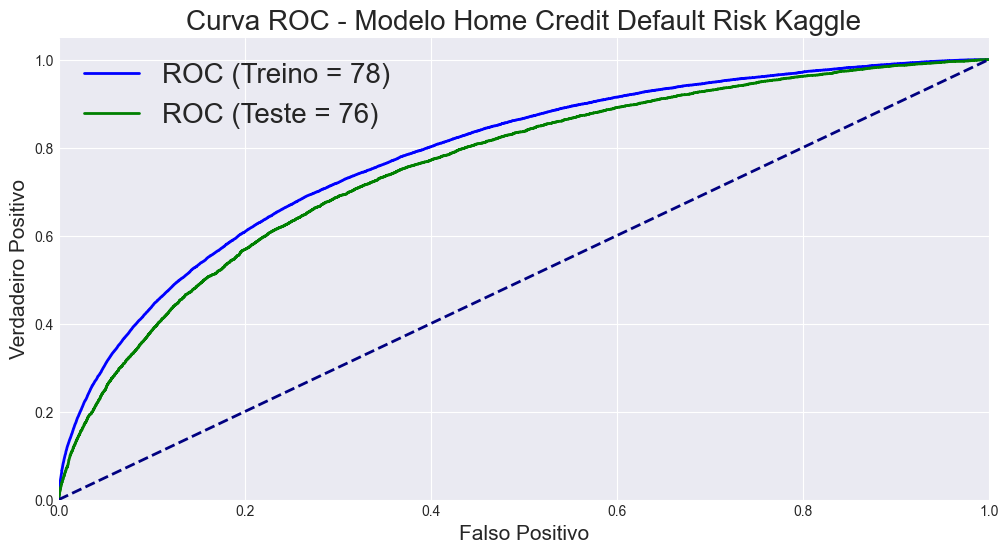

Acurácia - Treino: 92.05392
Acurácia - Teste: 91.66382
KS - Treino: 42.341
KS - Teste: 38.897
Gini - Treino: 56.952
Gini - Teste: 51.593999999999994
Área da Curva Roc - Treino: 78.476
Área da Curva Roc - Teste: 75.797


In [37]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(12,6))

lw = 2

plt.plot(fpr_train, tpr_train, color='blue',lw=lw, label='ROC (Treino = %0.0f)' % roc_auc_train)
plt.plot(fpr_test, tpr_test, color='green',lw=lw, label='ROC (Teste = %0.0f)' % roc_auc_test)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Falso Positivo', fontsize=15)
plt.ylabel('Verdadeiro Positivo', fontsize=15)
plt.legend(loc="lower right")
plt.legend(fontsize=20) 
plt.title('Curva ROC - Modelo Home Credit Default Risk Kaggle', fontsize=20)
plt.show()


print('Acurácia - Treino:', acuracia_train)
print('Acurácia - Teste:', acuracia_test)
print('KS - Treino:', train_ks)
print('KS - Teste:', test_ks)
print('Gini - Treino:', gini_train)
print('Gini - Teste:', gini_test)
print('Área da Curva Roc - Treino:', roc_auc_train)
print('Área da Curva Roc - Teste:', roc_auc_test)

# Ajuste do Score

In [38]:
# Preparando base com Score
abt_scored = X_test.copy()

abt_scored["Score"] = modelo_carregado.predict_proba(abt_scored)[:,0]
abt_scored["TARGET"] = abt["TARGET"]

#xvars = abt_scored.drop('TARGET',axis=1)

abt_scored

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,Score,TARGET
181513,310380,Cash loans,F,Y,Y,3,270000.0,359374.5,28944.0,333000.0,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0.641306,1
15617,118224,Cash loans,M,Y,Y,0,180000.0,490495.5,50391.0,454500.0,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0.901264,0
126025,246140,Cash loans,F,N,Y,0,189000.0,781920.0,45018.0,675000.0,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.882021,1
4745,105547,Cash loans,F,N,N,0,63000.0,227493.0,14836.5,207000.0,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.953631,0
263834,405483,Cash loans,F,N,Y,3,135000.0,573408.0,29407.5,495000.0,...,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.873624,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2434,102840,Cash loans,F,Y,Y,1,103500.0,490500.0,15952.5,490500.0,...,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.990884,0
15398,117972,Cash loans,M,N,Y,0,270000.0,450441.0,53586.0,405000.0,...,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.934284,0
13703,115971,Cash loans,F,N,Y,0,67500.0,871065.0,28917.0,661500.0,...,0,0,0.0,0.0,0.0,1.0,0.0,1.0,0.815440,0
101206,217503,Cash loans,M,Y,N,0,135000.0,270000.0,21460.5,270000.0,...,0,0,0.0,0.0,0.0,0.0,0.0,2.0,0.710110,0


In [39]:
# Ordenando as Faixas de Score
df_abc = abt_scored.copy()
df_abc = df_abc[['Score', 'TARGET']]

df_abc['faixa'] = pd.qcut(abt_scored['Score'], 10, labels=False, duplicates='drop')
#display(df_abc)


df_agr = df_abc.groupby(by='faixa').aggregate('Score').max()
df_agr = pd.DataFrame(df_agr, columns=["Score"])
df_agr

,Score
faixa,
0,0.701113
1,0.788625
2,0.838979
3,0.873560
4,0.899088
5,0.919323
6,0.936366
7,0.950943
8,0.965518


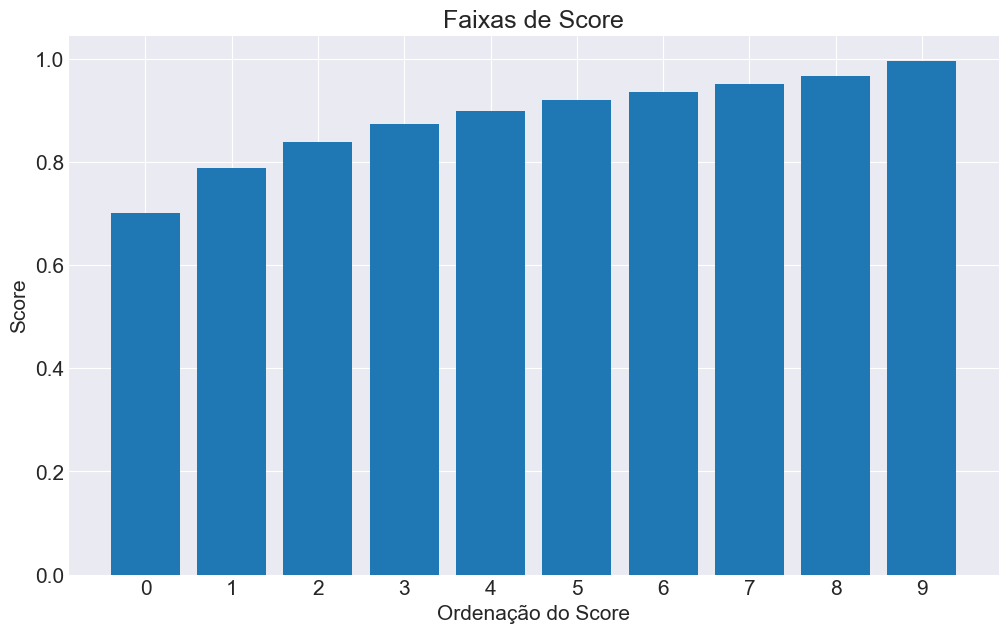

In [40]:
# Visualizando as Faixas de Score



# Make a random dataset:
height = df_agr.Score
bars = df_agr.index
y_pos = np.arange(len(bars))

plt.figure(figsize=(12, 7))
plt.rcParams.update({'font.size': 15})
# Create bars
plt.bar(y_pos, height)

# Create names on the x-axis
plt.xticks(y_pos, bars)

# setting label of y-axis
plt.ylabel("Score")
 
# setting label of x-axis
plt.xlabel("Ordenação do Score")
plt.title("Faixas de Score")

# Show graphic
plt.show()

In [41]:
faixas_cima = abt_scored[(abt_scored.Score  > float(df_agr.iloc[4]))]
faixas_cima = faixas_cima.drop('Score', axis=1)
y_faixas_cima = faixas_cima["TARGET"]
faixas_cima = faixas_cima.drop('TARGET', axis=1)


prev_faixas_cima = modelo_carregado.predict(faixas_cima)

# Visualizando Métricas com o novo corte

from sklearn.metrics import classification_report

report = classification_report(y_faixas_cima, prev_faixas_cima)
print(report)

C:\Users\kleub\AppData\Local\Temp\ipykernel_31664\2503283877.py:1: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  faixas_cima = abt_scored[(abt_scored.Score  > float(df_agr.iloc[4]))]


              precision    recall  f1-score   support

           0       0.97      1.00      0.99     29863
           1       0.00      0.00      0.00       888

    accuracy                           0.97     30751
   macro avg       0.49      0.50      0.49     30751
weighted avg       0.94      0.97      0.96     30751



c:\Users\kleub\Documents\Projetos_Git\Prevencao_Inadimplencia_Emprestimos\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kleub\Documents\Projetos_Git\Prevencao_Inadimplencia_Emprestimos\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kleub\Documents\Projetos_Git\Prevencao_Inadimplencia_Emprestimos\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. U

In [42]:
# Matriz de Confusão
from sklearn.metrics import confusion_matrix

cm_cima = confusion_matrix(y_faixas_cima, prev_faixas_cima)
cm_cima

array([[29863,     0],
       [  888,     0]], dtype=int64)

In [43]:
print("Nas faixas de cima, em", int(cm_cima[0,0]) + int(cm_cima[1,0]), "empréstimos com default previstas pelo modelo, em", cm_cima[1,0], "ele afirma errôneamente que não é Default;")

print("Aprova automaticamente",round(int(cm_cima[0,0]) / int(len(abt_scored[(abt_scored.TARGET  == 0)]))*100,2), "% dos empréstimos 'bons'")

print("Aproximadamente", round(round(int(cm_cima[1,0]) + int(cm_cima[1,1])) / int(len(abt_scored[(abt_scored.TARGET  == 1)]))*100,2),"% dos empréstimos 'ruins' estão nas faixas maiores")

Nas faixas de cima, em 30751 empréstimos com default previstas pelo modelo, em 888 ele afirma errôneamente que não é Default;
Aprova automaticamente 52.82 % dos empréstimos 'bons'
Aproximadamente 17.89 % dos empréstimos 'ruins' estão nas faixas maiores


In [44]:
faixas_baixo = abt_scored[(abt_scored.Score  <= float(df_agr.iloc[1]))]
faixas_baixo = faixas_baixo.drop('Score', axis=1)
y_faixas_baixo = faixas_baixo["TARGET"]
faixas_baixo = faixas_baixo.drop('TARGET', axis=1)


prev_faixas_baixo = modelo_carregado.predict(faixas_baixo)

# Visualizando Métricas com o novo corte

from sklearn.metrics import classification_report

report = classification_report(y_faixas_baixo, prev_faixas_baixo)
print(report)

C:\Users\kleub\AppData\Local\Temp\ipykernel_31664\1522287869.py:1: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  faixas_baixo = abt_scored[(abt_scored.Score  <= float(df_agr.iloc[1]))]


              precision    recall  f1-score   support

           0       0.81      0.94      0.87      9718
           1       0.42      0.17      0.24      2583

    accuracy                           0.78     12301
   macro avg       0.62      0.55      0.56     12301
weighted avg       0.73      0.78      0.74     12301



In [45]:
# Matriz de Confusão
from sklearn.metrics import confusion_matrix

cm_baixo = confusion_matrix(y_faixas_baixo, prev_faixas_baixo)
cm_baixo

array([[9119,  599],
       [2146,  437]], dtype=int64)

In [46]:
print("Nas faixas de baixo, possui", int(cm_baixo[0,0]) + int(cm_baixo[0,1]), "Operações sem Default;")

print("Ou seja, aproximadamente", round((int(cm_baixo[0,0]) + int(cm_baixo[0,1])) / int(len(abt_scored[(abt_scored.TARGET  == 0)]))*100,2),"% dos empréstimos 'bons' serão recusados;")

print("Evita prejuizos em cerca de", round((int(cm_baixo[1,0]) + int(cm_baixo[1,1])) / int(len(abt_scored[(abt_scored.TARGET  == 1)]))*100,2),"% dos empréstimos 'ruins'.")

Nas faixas de baixo, possui 9718 Operações sem Default;
Ou seja, aproximadamente 17.19 % dos empréstimos 'bons' serão recusados;
Evita prejuizos em cerca de 52.02 % dos empréstimos 'ruins'.


In [47]:
faixas_meio = abt_scored[(abt_scored.Score  > float(df_agr.iloc[1])) & (abt_scored.Score  <= float(df_agr.iloc[4]))]
faixas_meio = faixas_meio.drop('Score', axis=1)
y_faixas_meio = faixas_meio["TARGET"]
faixas_meio = faixas_meio.drop('TARGET', axis=1)


prev_faixas_meio = modelo_carregado.predict(faixas_meio)

# Visualizando Métricas com o novo corte

from sklearn.metrics import classification_report

report = classification_report(y_faixas_meio, prev_faixas_meio)
print(report)

C:\Users\kleub\AppData\Local\Temp\ipykernel_31664\754084384.py:1: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  faixas_meio = abt_scored[(abt_scored.Score  > float(df_agr.iloc[1])) & (abt_scored.Score  <= float(df_agr.iloc[4]))]


              precision    recall  f1-score   support

           0       0.92      1.00      0.96     16957
           1       0.00      0.00      0.00      1494

    accuracy                           0.92     18451
   macro avg       0.46      0.50      0.48     18451
weighted avg       0.84      0.92      0.88     18451



c:\Users\kleub\Documents\Projetos_Git\Prevencao_Inadimplencia_Emprestimos\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kleub\Documents\Projetos_Git\Prevencao_Inadimplencia_Emprestimos\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kleub\Documents\Projetos_Git\Prevencao_Inadimplencia_Emprestimos\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. U

In [48]:
# Matriz de Confusão
from sklearn.metrics import confusion_matrix

cm_meio = confusion_matrix(y_faixas_meio, prev_faixas_meio)
cm_meio

array([[16957,     0],
       [ 1494,     0]], dtype=int64)

In [49]:
print("Aproximadamente", round(round(int(cm_meio[1,0]) + int(cm_meio[1,1])) / int(len(abt_scored[(abt_scored.TARGET  == 1)]))*100,2),"% dos empréstimos 'ruins' estão nas faixas intermediárias")

print("Aproximadamente", round(round(int(cm_meio[0,0]) + int(cm_meio[0,1])) / int(len(abt_scored[(abt_scored.TARGET  == 0)]))*100,2),"% dos empréstimos 'bons' estão nas faixas intermediárias")

Aproximadamente 30.09 % dos empréstimos 'ruins' estão nas faixas intermediárias
Aproximadamente 29.99 % dos empréstimos 'bons' estão nas faixas intermediárias
